## Predicting House Prices
A regression example. In this section, we'll predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on. Each feature in the input data has a different scale. For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, others between 0 and 100, and so on.

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Let's look at the data

In [4]:
train_data.shape

(404, 13)

In [5]:
test_data.shape

(102, 13)

In [ ]:
train_targets

### Preparing the data
It would be problematic to feed into a neural network values that all take widly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning difficult. A widespread best practice is standarization

In [7]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Note that the quantities used for normalizing the test data are computed using the training data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.
### Building network

In [8]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

The network ends with a single unit and no activation. This is a typical setup fir scakar regression. Here, because the last layer is purely linear, the network is free to learn to predict values in any range. Monitoring a new metric during training:*mean absolute error (MAE)*. It's the absolute value of the difference between predictions and the targets. For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average.
### Validating approach using K-fold validation
Since I have this part knowledge, there will be no explaination about cross_validation

In [10]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    # use for tracking
    print('processing fold #', i)
    
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],
     train_data[(i+1)*num_val_samples:]],
     axis=0)
    
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],
     train_targets[(i+1)*num_val_samples:]],
     axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs = num_epochs, batch_size = 1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
all_scores

[1.9059053659439087, 3.2479372024536133, 2.884260416030884, 2.3329639434814453]

In [12]:
np.mean(all_scores)

2.5927667319774628

The different runs do indeed show rather different validation scores. In this case, you're off by $2,400 on average, which is significant considering that the prices range from 10,000 to 50,000.
### Saving the validation logs at each fold

In [13]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    # use for tracking
    print('processing fold #', i)
    
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],
     train_data[(i+1)*num_val_samples:]],
     axis=0)
    
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],
     train_targets[(i+1)*num_val_samples:]],
     axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs = num_epochs, batch_size = 1, verbose=0)
    
    # print(history.history.keys())
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [14]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Plotting validationi scores

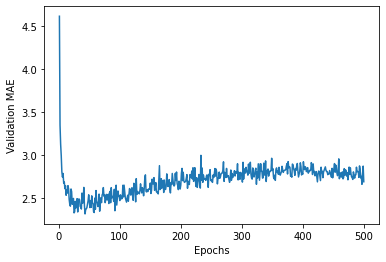

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let's do the following:
1. Omit the first 10 data points, which are on a different scale than the rest of curve
2. Replace each point with an exponential moving average of the previous points, to obtain a smooth curve

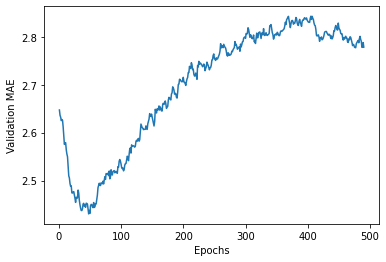

In [22]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1- factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smoothed_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smoothed_mae_history)+1), smoothed_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80epochs. Past that point, it begins overfitting. Once finishing tuning other parameters of the model, we can train a final production model on all of the training data, with best parameters, and then look at its performance on the test data.

In [23]:
model = build_model()
model.fit(train_data, train_targets,
         epochs = 80, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 18.0326 - mae: 2.7171


2.7170941829681396

Even worse, what a life :)
### Wrapping up
1. Mean Squared Error is a loss function commonly used for regression.
2. A common regression metric is mean absolute error (MAE).
3. When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
4. When little training data is availabel, it's preferable to use a small network with few hidden layers.